<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [ ]:
import re

import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

import matplotlib.pyplot as plt
import seaborn as sns

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
# Conectarnos a Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# El dataset fue descargado de aquí: https://www.kaggle.com/residentmario/exploring-elon-musk-tweets/data

data_elon = pd.read_csv("/content/drive/MyDrive/CEIA - NLP/Clase 4/Desafío/data_elonmusk.csv", encoding='latin1')
data_elon.drop(columns=["row ID","Time","Retweet from", "User"], inplace=True)
data_elon.head()

,Tweet
0,@MeltingIce Assuming max acceleration of 2 to ...
1,RT @SpaceX: BFR is capable of transporting sat...
2,@bigajm Yup :)
3,Part 2 https://t.co/8Fvu57muhM
4,Fly to most places on Earth in under 30 mins a...


In [ ]:
data_elon["clean tweet"] = [' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data_elon["Tweet"].iloc[i]).split()) for i in range(len(data_elon))]

In [ ]:
data_elon.head()

,Tweet,clean tweet
0,@MeltingIce Assuming max acceleration of 2 to ...,Assuming max acceleration of 2 to 3 g s but in...
1,RT @SpaceX: BFR is capable of transporting sat...,RT BFR is capable of transporting satellites t...
2,@bigajm Yup :),Yup
3,Part 2 https://t.co/8Fvu57muhM,Part 2
4,Fly to most places on Earth in under 30 mins a...,Fly to most places on Earth in under 30 mins a...


In [ ]:
data_elon.drop(columns="Tweet", inplace=True)

In [ ]:
print("Cantidad de documentos:", data_elon.shape[0])

Cantidad de documentos: 3218


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [ ]:
# Vistazo a las primeras filas
data_elon.iloc[:15,0]

0     Assuming max acceleration of 2 to 3 g s but in...
1     RT BFR is capable of transporting satellites t...
2                                                   Yup
3                                                Part 2
4     Fly to most places on Earth in under 30 mins a...
5     RT Supporting the creation of a permanent self...
6     BFR will take you anywhere on Earth in less th...
7     Mars City Opposite of Earth Dawn and dusk sky ...
8                                       Moon Base Alpha
9     Will be announcing something really special at...
10    RT Nine years ago today Falcon 1 became the fi...
11                       Just another day in the office
12                          com Congrats Mom I love you
13    RT I m so excited to say that I m now official...
14    Prev ideas for paying 10B dev cost incl Kickst...
Name: clean tweet, dtype: object

In [ ]:
# Concatenamos todos los rows en un solo valor
corpus = data_elon.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Assuming max acceleration of 2 to 3 g s but in a comfortable direction Will feel like a mild to moder RT BFR is capable of transporting satellites to orbit crew and cargo to the Station and completing missions to the Moon an Yup Part 2 Fly to most places on Earth in under 30 mins and anywhere in under 60 Cost per seat should be RT Supporting the creation of a permanent self sustaining human presence on Mars BFR will take you anywhere on Earth in less than 60 mins Mars City Opposite of Earth Dawn and dusk sky are blue on Mars and day sky is red Moon Base Alpha Will be announcing something really special at today s talk RT Nine years ago today Falcon 1 became the first privately developed liquid fuel rocket to orbit Earth Just another day in the office com Congrats Mom I love you RT I m so excited to say that I m now officially a COVERGIRL at 69 Beauty is for all ages COVERGIRLMADE Prev ideas for paying 10B dev cost incl Kickstarter collecting underpants which turned out to be um less l

In [ ]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['assuming',
 'max',
 'acceleration',
 'of',
 '2',
 'to',
 '3',
 'g',
 's',
 'but',
 'in',
 'a',
 'comfortable',
 'direction',
 'will',
 'feel',
 'like',
 'a',
 'mild',
 'to']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 42337


In [ ]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['assuming', 'max', 'acceleration', 'of'],
 ['max', 'acceleration', 'of', '2'],
 ['acceleration', 'of', '2', 'to'],
 ['of', '2', 'to', '3'],
 ['2', 'to', '3', 'g'],
 ['to', '3', 'g', 's'],
 ['3', 'g', 's', 'but'],
 ['g', 's', 'but', 'in'],
 ['s', 'but', 'in', 'a'],
 ['but', 'in', 'a', 'comfortable'],
 ['in', 'a', 'comfortable', 'direction'],
 ['a', 'comfortable', 'direction', 'will'],
 ['comfortable', 'direction', 'will', 'feel'],
 ['direction', 'will', 'feel', 'like'],
 ['will', 'feel', 'like', 'a'],
 ['feel', 'like', 'a', 'mild'],
 ['like', 'a', 'mild', 'to'],
 ['a', 'mild', 'to', 'moder'],
 ['mild', 'to', 'moder', 'rt'],
 ['to', 'moder', 'rt', 'bfr']]

In [ ]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[2121, 237, 956, 4],
 [237, 956, 4, 71],
 [956, 4, 71, 2],
 [4, 71, 2, 48],
 [71, 2, 48, 1348],
 [2, 48, 1348, 8],
 [48, 1348, 8, 18],
 [1348, 8, 18, 6],
 [8, 18, 6, 3],
 [18, 6, 3, 2122],
 [6, 3, 2122, 2123],
 [3, 2122, 2123, 16],
 [2122, 2123, 16, 957],
 [2123, 16, 957, 38],
 [16, 957, 38, 3],
 [957, 38, 3, 3134],
 [38, 3, 3134, 2],
 [3, 3134, 2, 3135],
 [3134, 2, 3135, 7],
 [2, 3135, 7, 1642]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 42333


### 3 - Input y target

In [ ]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(42333, 3)
(42333,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'to',
 3: 'a',
 4: 'of',
 5: 'is',
 6: 'in',
 7: 'rt',
 8: 's',
 9: 'for',
 10: 'and',
 11: 'on',
 12: 'it',
 13: 'tesla',
 14: 'that',
 15: 'i',
 16: 'will',
 17: 'be',
 18: 'but',
 19: 'at',
 20: 'we',
 21: 'this',
 22: 'model',
 23: 't',
 24: 'you',
 25: 'by',
 26: 'with',
 27: 'not',
 28: 'are',
 29: 'from',
 30: 'just',
 31: 'launch',
 32: 'all',
 33: 'good',
 34: 'was',
 35: 'as',
 36: 'no',
 37: 'about',
 38: 'like',
 39: 'so',
 40: 'rocket',
 41: 'my',
 42: 'falcon',
 43: 'yes',
 44: 'have',
 45: 'car',
 46: 'or',
 47: 'can',
 48: '3',
 49: 'first',
 50: 'if',
 51: 'more',
 52: 'an',
 53: 'next',
 54: '1',
 55: 'now',
 56: 'our',
 57: '9',
 58: 'there',
 59: 'would',
 60: 'dragon',
 61: 'should',
 62: 'landing',
 63: 'do',
 64: 'new',
 65: 'has',
 66: 'out',
 67: 'what',
 68: 'than',
 69: 'one',
 70: 'thanks',
 71: '2',
 72: 'spacex',
 73: 'time',
 74: 'cars',
 75: 'great',
 76: 'x',
 77: 'they',
 78: 'autopilot',
 79: 'up',
 80: 'some',
 81: 'right',
 82: 'only'

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6430

In [ ]:
y_data_int

array([   4,   71,    2, ...,  221,   38, 6430])

In [ ]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(42333, 6430)

### 4 - Entrenar el modelo

In [ ]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [ ]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6430

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 6430 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 6430 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 3, 5)              32155     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3, 128)            35840     
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 6430)              212190    
Total params: 331,673
Trainable params: 331,673
Non-trainable params: 0
________________________________________________

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1059/1059 [==============================] - 42s 36ms/step - loss: 7.3476 - accuracy: 0.0272 - val_loss: 7.3676 - val_accuracy: 0.0293
Epoch 2/50
1059/1059 [==============================] - 38s 36ms/step - loss: 6.9599 - accuracy: 0.0296 - val_loss: 7.5183 - val_accuracy: 0.0340
Epoch 3/50
1059/1059 [==============================] - 38s 36ms/step - loss: 6.8719 - accuracy: 0.0339 - val_loss: 7.5548 - val_accuracy: 0.0390
Epoch 4/50
1059/1059 [==============================] - 38s 36ms/step - loss: 6.7761 - accuracy: 0.0393 - val_loss: 7.6657 - val_accuracy: 0.0409
Epoch 5/50
1059/1059 [==============================] - 38s 36ms/step - loss: 6.6568 - accuracy: 0.0441 - val_loss: 7.7990 - val_accuracy: 0.0423
Epoch 6/50
1059/1059 [==============================] - 37s 35ms/step - loss: 6.5537 - accuracy: 0.0470 - val_loss: 7.8622 - val_accuracy: 0.0456
Epoch 7/50
1059/1059 [==============================] - 39s 37ms/step - loss: 6.4708 - accuracy: 0.0490 - val_loss: 8.0090 -

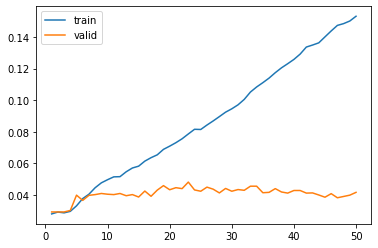

In [ ]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
!pip install gradio --quiet

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 1.9 MB 35.2 MB/s 
     |████████████████████████████████| 206 kB 38.6 MB/s 
     |████████████████████████████████| 961 kB 37.0 MB/s 
     |████████████████████████████████| 3.5 MB 35.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://52064.gradio.app
Interface loading below...


KeyboardInterrupt: ignored

### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='btc'

generate_seq(model, tok, input_text, max_length=3, n_words=25)

'btc improvement tax new systems                     '

### 7 - Conclusiones
El modelo tuvo un bastante mal desempeño al intentar predecir la siguiente palabra de una secuencia de palabras. Tal cual como sucedió con la práctica en clase, comenzamos a experimentar overfitting durante el entrenamiento. 

En contraste con el modelo planteado en clase, esta vez utilizamos una capa bidireccional esperando obtener un mejor resultado, pero no se lograron grandes mejoras.